In [25]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array
from models.autoencoder import Autoencoder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Step 0: Generate FEM solutions

In [ ]:
def generate_fem_u_matrices(f_values, input_shape, u_file_name, f_file_name):
    a, b, k, M = 0, 1, 1, 255
    c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
    M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)
    f_matrices = []
    u_matrices = []

    for f_value in tqdm(f_values, desc="Generating FEM solutions"):
        f = lambda x: np.full(x.shape[0], f_value)
        u_D = lambda x: x[:, 0] * 0
        fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
        fem_u_reshaped = fem_u.reshape(input_shape)
        f_matrix = np.full(input_shape, f_value)
        # f_matrix = Dirichlet_bc_array(f_matrix)
        u_matrices.append(fem_u_reshaped)
        f_matrices.append(f_matrix)

    u_matrices = np.array(u_matrices)
    f_matrices = np.array(f_matrices)
    np.save(u_file_name, u_matrices)
    np.save(f_file_name, f_matrices)
    print(f"Saved {len(u_matrices)} u matrices to {u_file_name}")
    print(f"Saved {len(f_matrices)} f matrices to {f_file_name}")
    return u_matrices, f_matrices

In [ ]:
f_values = np.arange(-5000, 5000, 2)
input_shape = (256, 256)
u_file_name = './u_dataset.npy'
f_file_name = './f_dataset.npy'

In [ ]:
u_matrices, f_matrices = generate_fem_u_matrices(f_values, input_shape, u_file_name, f_file_name)
print(f"Generated {len(u_matrices)} u matrices and f matrices")

# Step 1: VAE Model

In [ ]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_matrices = np.load(f'./{u_file_name}')
dataset = PoissonDataset(u_matrices)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [15]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.LeakyReLU(negative_slope=0.01)
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 512)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 32 * 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            ResidualBlock(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            ResidualBlock(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.LeakyReLU(negative_slope=0.01)
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 512)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 32 * 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Unflatten(1, (128, 32, 32)),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            ResidualBlock(32),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

In [19]:
def he_weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [20]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
vae_model = VAE(latent_dim=128).to(device)
vae_model.apply(he_weights_init)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

num_epochs = 5000
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    vae_model.train()
    train_loss = 0
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar, z = vae_model(u_tensor)
        loss = vae_loss(recon_x, u_tensor, mu, logvar)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0) # 기울기 클리핑
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')

    # 학습률 스케쥴러 업데이트
    scheduler.step(train_loss)

    # 10 에폭마다 재구성 이미지 시각화
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            vae_model.eval()
            indices = np.random.choice(len(u_matrices), size=10, replace=False)  # 무작위로 10개의 샘플 선택
            u_tensor = u_matrices[indices]
            u_tensor = torch.tensor(u_tensor).unsqueeze(1).float().to(device)
            recon_x, _, _, _ = vae_model(u_tensor)
            recon_x = recon_x.cpu().numpy()
            
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                axes[0, i].imshow(u_tensor[i, 0].cpu(), cmap='viridis')
                axes[0, i].axis('off')
                axes[1, i].imshow(recon_x[i, 0], cmap='viridis')
                axes[1, i].axis('off')
            plt.show()
        vae_model.train()
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = vae_model.state_dict()

torch.save(vae_model.state_dict(), 'last_vae_model.pth')
torch.save(best_model_wts, 'best_vae_model.pth')

print(f'Last Loss: {train_loss:.4f} Last vae_model saved to last_vae_model.pth')
print(f'Best Loss: {best_loss:.4f} Best vae_model saved to best_vae_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


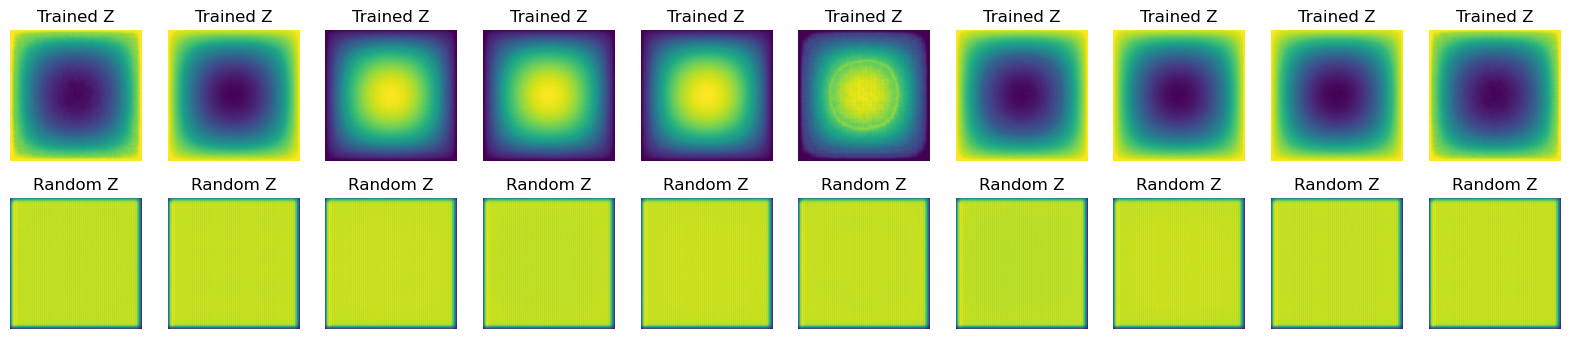

In [87]:
vae_model = VAE(latent_dim=128).to(device)
vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

z_list = []
vae_model.eval()
with torch.no_grad():
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        mu, logvar = vae_model.encode(u_tensor)
        z = vae_model.reparameterize(mu, logvar)
        z_list.append(z.cpu().numpy())

z_samples_trained = np.concatenate(z_list, axis=0)
z_samples_trained = torch.tensor(z_samples_trained[:10]).to(device)

with torch.no_grad():
    generated_u_trained = vae_model.decode(z_samples_trained)
    generated_u_trained = generated_u_trained.cpu().numpy()

latent_dim = 128
num_samples = 10

z_samples_random = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    generated_u_random = vae_model.decode(z_samples_random)
    generated_u_random = generated_u_random.cpu().numpy()

fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
for i in range(num_samples):
    axes[0, i].imshow(generated_u_trained[i, 0], cmap='viridis')
    axes[0, i].axis('off')
    axes[0, i].set_title("Trained Z")
    axes[1, i].imshow(generated_u_random[i, 0], cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title("Random Z")
plt.show()


# Step 2: Latent Space Regression Model

In [ ]:
class LatentSpaceDataset(Dataset):
    def __init__(self, f_matrices, latent_vectors):
        self.f_matrices = f_matrices
        self.latent_vectors = latent_vectors

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_tensor = torch.tensor(self.f_matrices[idx]).unsqueeze(0).float()  # (1, H, W)
        latent_tensor = torch.tensor(self.latent_vectors[idx]).float()
        return f_tensor, latent_tensor

In [ ]:
class LatentRegressionModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(LatentRegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 32 * 32, latent_dim)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_matrices = np.load(f'./{u_file_name}')
dataset = PoissonDataset(u_matrices)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

latent_vectors = []
with torch.no_grad():
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        _, _, _, z = vae_model(u_tensor)
        latent_vectors.append(z.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
np.save('latent_vectors.npy', latent_vectors)

In [ ]:
f_matrices = np.load(f'./f_dataset.npy')
latent_vectors = np.load('latent_vectors.npy')

dataset = LatentSpaceDataset(f_matrices, latent_vectors)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
regression_model = LatentRegressionModel(latent_dim=128).to(device)
regression_model.apply(he_weights_init)

optimizer = optim.Adam(regression_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    regression_model.train()
    train_loss = 0
    for f_tensor, latent_vector in train_loader:
        f_tensor = f_tensor.to(device)
        latent_vector = latent_vector.to(device)
        optimizer.zero_grad()
        predicted_latent = regression_model(f_tensor)
        loss = criterion(predicted_latent, latent_vector)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = regression_model.state_dict()

torch.save(regression_model.state_dict(), 'last_regression_model.pth')
torch.save(best_model_wts, 'best_regression_model.pth')

print(f'Last Loss: {train_loss:.4f} Last regression_model saved to last_regression_model.pth')
print(f'Best Loss: {best_loss:.4f} Best regression_model saved to best_regression_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Step 3: Inference Model

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self, regression_model, vae_model):
        super(InferenceModel, self).__init__()
        self.regression_model = regression_model
        self.vae_model = vae_model

    def forward(self, f_tensor):
        latent_vector = self.regression_model(f_tensor)
        reconstructed_u = self.vae_model.decode(latent_vector)
        return reconstructed_u

regression_model.load_state_dict(torch.load('best_regression_model.pth'))
regression_model.eval()

vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

inference_model = InferenceModel(regression_model, vae_model).to(device)

# Test inference with a new f_matrix
f_value = 10  # example f_value
new_f_matrix = np.full(input_shape, f_value)
new_f_tensor = torch.tensor(new_f_matrix).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    predicted_u = inference_model(new_f_tensor)

predicted_u = predicted_u.squeeze().cpu().numpy()

plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()
plt.title(f'Predicted u for f={f_value}')
plt.show()
